<a href="https://colab.research.google.com/github/artemtu/projects-by-artemtu/blob/main/Peterburg_real_estate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Pandas_files/my_projects/real_estate_data.csv', sep='\t')

## Open the data

In [4]:
df.info()

df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [6]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.360000
living_area,8.030000
floor,0.000000
is_apartment,88.290000


### Вывод

Изучили данные. Выявили следующие пропуски:
1. Высота потолков. Пропущено 38,8% значений. Игнорировать не можем, будем заполнять пропуски по медиане.
2. Количество этажей. Пропущено 0,36% значений. От этих пропусков можем избавиться. На конечный результат это не повлияет
3. Жилая площадь. Пропущено 8,03% значений. Для нас это очень важный параметр, будем заполнять пропуски с помощью коэффициентов по соотнешию жилой площади к общей
4. Площадь кухни. Пропущено 9,61% значений. Для нас это очень важный параметр, будем заполнять пропуски с помощью коэффициентов по соотнешию площади кухни к общей
5. Апартаменты. Скорее всего, человек не поставил галочку при формировании объявления. Заменим все пропуски на False
6. Балконы. Пропущено 48,61% значений. Если человек не указал кол-во балконов, наверное их нет. Балкон - это своеобразный приятный бонус в квартире, вряд ли кто-то умышленно бы отказался от заполнения этого пункта в объявлении. На сайте Яндекс.Недвижимость можно отфильтровать предложения по квартирам с опцией "Балкон"
7. Название населённого пункта. Пропущено 0,21% значений. От таких пропусков мы можем избавиться
8. Данные, которые были добавлены картографическим способом: расстояние до центра, аэропорта, парка, водоёма. Здесь пропущено от 23 до 65% значений. Мы заполним то, что сможем по медиане в соответствии с населённым пунктом, а оставшиеся пропуски проигнорируем
9. days_exposition. Пропущено 13,42% значений. Заполнять пропуски не будем, так как мы не знаем, была ли продана квартира в момент выгрузки данных или нет

1. ceiling_height - we have no 38.8 per cent of values. I'm going to fill gaps in the median
2. floors_total - we have no 0.36 per cent of values. I'll drop it
3. living_area - we have no 8.03 per cent of values. This column is so important for us. I'm going to fill gaps with a special coefficient
4. kitchen_area - we have no 9.61 per cent of values. This column is so important for us. I'm going to fill gaps with a special coefficient
5. is_apartment - we have a gap because users didn't use the checkbox on a website
6. balcony - we have no 48.6 per cent of values. I guess that person didn't use the especially checkbox on the web version because he hasn't a balcony
7. locality_name - only 0.21 per cent gaped. I'll drop it
8. The data in columns from airports_nearest to ponds_nearest was added automatically, Yandex maps added this data to every announcement. I'll fill gaps on a median value
9. days_exposition - we have no 13.4 per cent of values. I won't fill gaps because we don't know how many days/weeks ago announcements were added

## Data preprocessing

In [7]:
df['live_coef'] = df['living_area'] / df['total_area'] # coefficient living area to total area
df['kitchen_coef']  = df['kitchen_area'] / df['total_area'] # coefficient kitchen area to total area

In [8]:
liv_coef_dict = df.groupby('rooms')['live_coef'].median().to_dict() # create a dictionary with median values on rooms
kit_coef_dict = df.groupby('rooms')['kitchen_coef'].median().to_dict() 

In [9]:
df['live_coef'] = df['live_coef'].fillna(df['rooms'].map(liv_coef_dict)) # filling gaps in live_coef on the dictionary
df['kitchen_coef'] = df['kitchen_coef'].fillna(df['rooms'].map(kit_coef_dict))
df['kitchen_coef'] = df['kitchen_coef'].fillna(0)

In [10]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.360000
living_area,8.030000
floor,0.000000
is_apartment,88.290000


In [11]:
df['living_area'] = df['living_area'].fillna(df['total_area']*df['live_coef']) # filling gaps in living_area
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area']*df['kitchen_coef']) # filling gaps in kithen_area

In [12]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.360000
living_area,0.000000
floor,0.000000
is_apartment,88.290000


In [13]:
df['is_apartment'] = df['is_apartment'].fillna(False) 

In [14]:
df.dropna(subset=['floors_total', 'locality_name'], inplace=True)

In [15]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.550000
floors_total,0.000000
living_area,0.000000
floor,0.000000
is_apartment,0.000000


In [16]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [17]:
def no_upper(string):                   
  for i in range(len(string)):
    if string[i].isupper():
        return string[i: len(string)]
# thankfully this function, we dropped the first part of the name of city, etc 

In [18]:
df['locality_name'] = df['locality_name'].apply(no_upper) # changing name of cities

In [19]:
df['locality_name'].unique() # check out the column

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [20]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,False,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,False,False,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.612500,0.148214


In [21]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median()) # filling gaps on median

In [22]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,0.000000
floors_total,0.000000
living_area,0.000000
floor,0.000000
is_apartment,0.000000


In [23]:
df['balcony'] = df['balcony'].fillna(0)

In [24]:
df['airports_nearest'] = df['airports_nearest'].fillna(df.groupby('locality_name')['airports_nearest'].transform('median'))

df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(df.groupby('locality_name')['cityCenters_nearest'].transform('median'))

df['parks_around3000'] = df['parks_around3000'].fillna(df.groupby('locality_name')['parks_around3000'].transform('median'))

df['parks_nearest'] = df['parks_nearest'].fillna(df.groupby('locality_name')['parks_nearest'].transform('median'))

df['ponds_nearest'] = df['ponds_nearest'].fillna(df.groupby('locality_name')['ponds_nearest'].transform('median'))


In [25]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,0.000000
floors_total,0.000000
living_area,0.000000
floor,0.000000
is_apartment,0.000000


In [26]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition']) 

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

## Make calculations and add it in the table

In [28]:
df['weekday'] = pd.DatetimeIndex(df['first_day_exposition']).weekday # add a new column with weekday

In [29]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.472222,0.231481,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,584.5,81.0,0.460396,0.272277,1
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.612500,0.148214,3


In [30]:
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month

In [31]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday,month
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.472222,0.231481,3,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,584.5,81.0,0.460396,0.272277,1,12
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.612500,0.148214,3,8


In [32]:
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

In [33]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.472222,0.231481,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,584.5,81.0,0.460396,0.272277,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.612500,0.148214,3,8,2015


In [34]:
df['price_per_square_meter'] = df['last_price'] / df['total_area']

In [35]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday,month,year,price_per_square_meter
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.472222,0.231481,3,3,2019,120370.370370
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,584.5,81.0,0.460396,0.272277,1,12,2018,82920.792079
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.612500,0.148214,3,8,2015,92785.714286


In [36]:
df['proportion_living_to_total_area'] = df['living_area'] / df['total_area']

df['proportion_kitchen_to_total_area'] = df['kitchen_area'] / df['total_area']

In [37]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday,month,year,price_per_square_meter,proportion_living_to_total_area,proportion_kitchen_to_total_area
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.472222,0.231481,3,3,2019,120370.370370,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,584.5,81.0,0.460396,0.272277,1,12,2018,82920.792079,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.612500,0.148214,3,8,2015,92785.714286,0.612500,0.148214


In [38]:
def floor_category(row): # function for adding a nubmer of floor: first, last or other. It will add in a new column
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['floor_category'] = df.apply(floor_category, axis=1)

In [39]:
df.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday,month,year,price_per_square_meter,proportion_living_to_total_area,proportion_kitchen_to_total_area,floor_category
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.472222,0.231481,3,3,2019,120370.370370,0.472222,0.231481,другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,584.5,81.0,0.460396,0.272277,1,12,2018,82920.792079,0.460396,0.272277,первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.612500,0.148214,3,8,2015,92785.714286,0.612500,0.148214,другой


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   total_images                      23565 non-null  int64         
 1   last_price                        23565 non-null  float64       
 2   total_area                        23565 non-null  float64       
 3   first_day_exposition              23565 non-null  datetime64[ns]
 4   rooms                             23565 non-null  int64         
 5   ceiling_height                    23565 non-null  float64       
 6   floors_total                      23565 non-null  float64       
 7   living_area                       23565 non-null  float64       
 8   floor                             23565 non-null  int64         
 9   is_apartment                      23565 non-null  bool          
 10  studio                            23565 non-nu

In [41]:
df[['total_area', 'ceiling_height', 'living_area', 'kitchen_area', 'price_per_square_meter']] = df[['total_area', 'ceiling_height', 'living_area', 'kitchen_area', 'price_per_square_meter']].astype(int)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   total_images                      23565 non-null  int64         
 1   last_price                        23565 non-null  float64       
 2   total_area                        23565 non-null  int64         
 3   first_day_exposition              23565 non-null  datetime64[ns]
 4   rooms                             23565 non-null  int64         
 5   ceiling_height                    23565 non-null  int64         
 6   floors_total                      23565 non-null  float64       
 7   living_area                       23565 non-null  int64         
 8   floor                             23565 non-null  int64         
 9   is_apartment                      23565 non-null  bool          
 10  studio                            23565 non-nu

## Exploratory data analysis

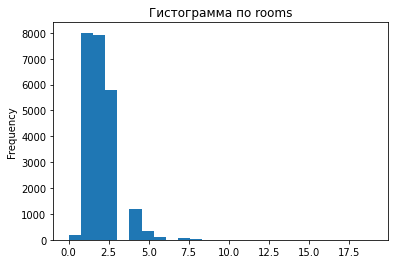

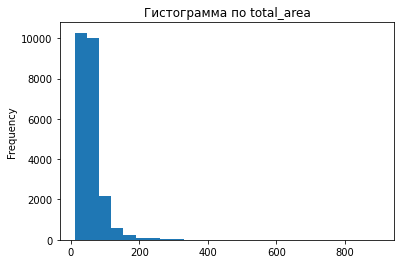

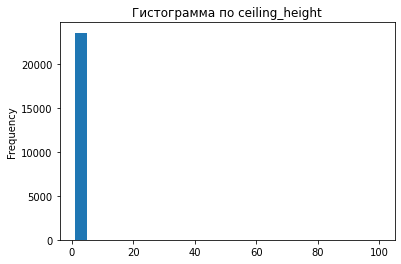

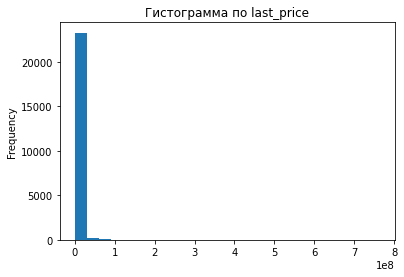

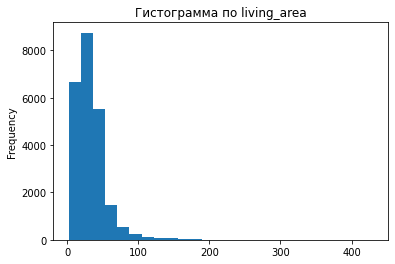

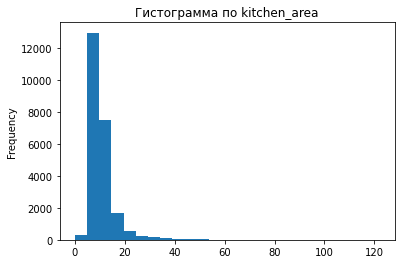

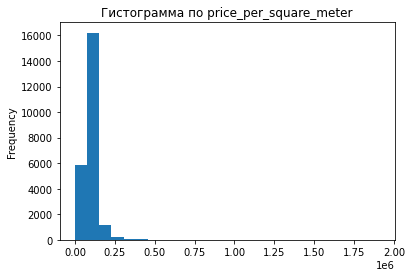

In [43]:
hist_list = ['rooms', 'total_area' , 'ceiling_height', 'last_price', 'living_area', 'kitchen_area', 'price_per_square_meter']
for column in hist_list:
  df[column].plot(
      kind = "hist",
      bins = 25,
     )
  plt.title("Гистограмма по " + str(column))
  plt.show()
hist_list
plt.show()

In [44]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'live_coef', 'kitchen_coef',
       'weekday', 'month', 'year', 'price_per_square_meter',
       'proportion_living_to_total_area', 'proportion_kitchen_to_total_area',
       'floor_category'],
      dtype='object')

In [45]:
df['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

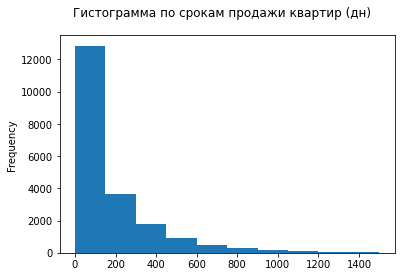

In [46]:
df['days_exposition'].plot(kind='hist', range=(0, 1500), subplots=True,sharex=True,sharey=True,title='Гистограмма по срокам продажи квартир (дн)')
plt.show()

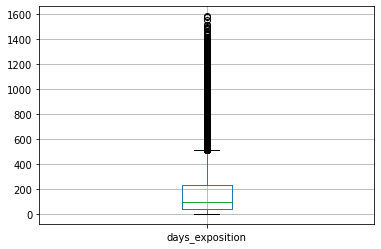

In [47]:
days_expos = df['days_exposition']
days_expos = days_expos.to_frame()
days_expos.boxplot()
plt.show()

In [48]:
rooms = df['rooms']
rooms = rooms.to_frame()
plt.show()

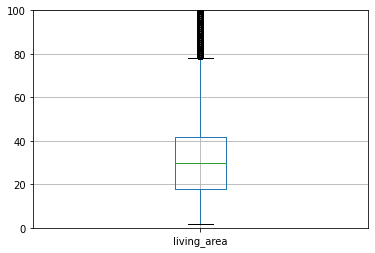

In [49]:
total_area = df['living_area']
total_area = total_area.to_frame()
total_area.boxplot()
plt.ylim(0, 100)
plt.show()

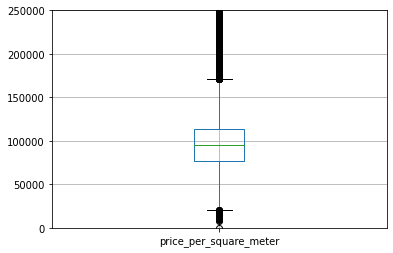

In [50]:
price_sq_meter = df['price_per_square_meter']
price_sq_meter = price_sq_meter.to_frame()
price_sq_meter.boxplot()
plt.ylim(0, 250000)
plt.show()

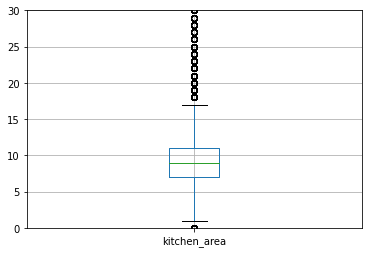

In [51]:
kitchen = df['kitchen_area']
kitchen = kitchen.to_frame()
kitchen.boxplot()
plt.ylim(0, 30)
plt.show()

In [86]:
df1 = df.query('(living_area < 80 ) and (days_exposition > 601) and(price_per_square_meter < 175000) and (rooms < 8) and (kitchen_area < 20)') # drop outlier from the data

In [53]:
df1[['rooms', 'total_area', 'ceiling_height', 'last_price', 'living_area', 'days_exposition', 'price_per_square_meter', 'kitchen_area' ]].describe() 

,rooms,total_area,ceiling_height,last_price,living_area,days_exposition,price_per_square_meter,kitchen_area
count,1010.000000,1010.000000,1010.000000,1.010000e+03,1010.000000,1010.000000,1010.000000,1010.000000
mean,2.118812,59.142574,2.117822,5.635903e+06,33.995050,847.689109,93813.608911,9.576238
std,0.981364,22.949625,0.325615,3.125496e+06,15.808535,203.974727,30561.620144,3.342466
min,0.000000,18.000000,2.000000,4.900000e+05,9.000000,602.000000,12542.000000,0.000000
25%,1.000000,41.000000,2.000000,3.500000e+06,19.000000,681.250000,73805.500000,7.000000
50%,2.000000,55.000000,2.000000,4.850000e+06,31.000000,792.000000,93240.000000,9.000000
75%,3.000000,73.000000,2.000000,6.837500e+06,44.000000,969.750000,113046.000000,11.750000
max,6.000000,156.000000,4.000000,1.850000e+07,79.000000,1580.000000,174583.000000,19.000000


In [54]:
df1[['last_price', 'price_per_square_meter', 'total_area', 'rooms', 'living_area', 'kitchen_area', 'ceiling_height', 'cityCenters_nearest']].corr()[['last_price', 'price_per_square_meter']].style.background_gradient('coolwarm')

,last_price,price_per_square_meter
last_price,1.000000,0.655762
price_per_square_meter,0.655762,1.000000
total_area,0.781592,0.094245
rooms,0.489539,-0.149777
living_area,0.672624,-0.015089
kitchen_area,0.605639,0.379921
ceiling_height,0.348417,0.188693
cityCenters_nearest,-0.419336,-0.416465


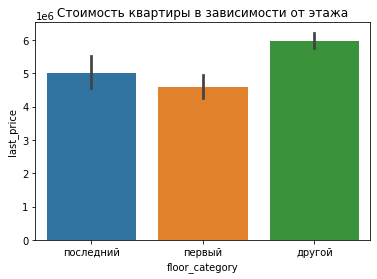

In [55]:
sns.barplot(x="floor_category", y="last_price", data=df1) # получаем график по группировке типа "этаж"
plt.title('Стоимость квартиры в зависимости от этажа')
plt.show()

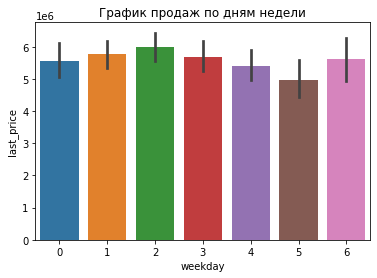

In [56]:
sns.barplot(x="weekday", y="last_price", data=df1) # график продаж по дням недели
plt.title('График продаж по дням недели')
plt.show()

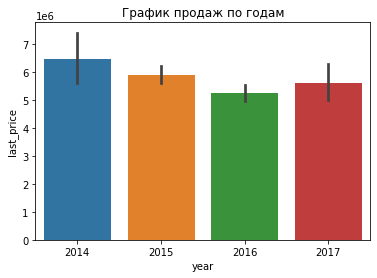

In [57]:
sns.barplot(x="year", y="last_price", data=df1) # график продаж по году
plt.title('График продаж по годам')
plt.show()

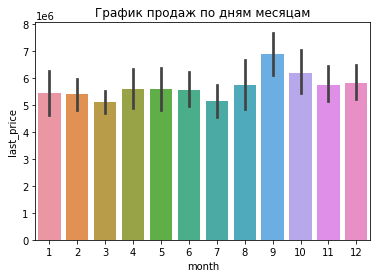

In [58]:
sns.barplot(x="month", y="last_price", data=df1) # график продаж по месяцам
plt.title('График продаж по дням месяцам')
plt.show()

In [59]:
df1.head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday,month,year,price_per_square_meter,proportion_living_to_total_area,proportion_kitchen_to_total_area,floor_category
23,11,2950000.0,32,2016-10-29,1,2,9.0,17,9,False,False,False,6,0.0,Санкт-Петербург,15414.0,14211.0,2.0,517.0,1.0,190.0,615.0,0.553125,0.190625,5,10,2016,92187,0.553125,0.190625,последний
76,12,2800000.0,55,2016-05-14,3,2,5.0,38,1,False,False,False,4,0.0,Кировск,NaN,NaN,NaN,NaN,NaN,NaN,606.0,0.696915,0.088929,5,5,2016,50816,0.696915,0.088929,первый
98,11,11700000.0,80,2014-12-10,3,2,5.0,55,3,False,False,False,11,0.0,Санкт-Петербург,11248.0,8767.0,1.0,666.0,0.0,504.0,831.0,0.688750,0.137500,2,12,2014,146250,0.688750,0.137500,другой
109,2,7497600.0,62,2015-12-08,2,2,5.0,35,5,False,False,False,9,0.0,Пушкин,14517.0,26670.0,1.0,517.0,0.0,444.0,1048.0,0.568000,0.152000,1,12,2015,119961,0.568000,0.152000,последний


In [60]:
ratio = df1.pivot_table(index='locality_name', values='price_per_square_meter', aggfunc=['mean', 'count'])

In [61]:
ratio.columns = ['mean', 'count']

In [62]:
ratio_by_ad = ratio.sort_values(by='count', ascending=False).head(10)

In [63]:
ratio_by_ad

,mean,count
locality_name,,
Санкт-Петербург,107272.655689,668
Кудрово,90629.130435,23
Мурино,82121.550000,20
Всеволожск,66997.350000,20
Гатчина,65177.000000,18
Пушкин,105999.388889,18
Петергоф,80752.214286,14
Шушары,80930.461538,13
Выборг,56665.272727,11


In [64]:
ratio_by_ad.sort_values(by='mean', ascending=False)

,mean,count
locality_name,,
Санкт-Петербург,107272.655689,668
Пушкин,105999.388889,18
Кудрово,90629.130435,23
Мурино,82121.550000,20
Шушары,80930.461538,13
Петергоф,80752.214286,14
Всеволожск,66997.350000,20
Гатчина,65177.000000,18
Выборг,56665.272727,11


In [65]:
saint_p = df1.query('(locality_name == "Санкт-Петербург")')

In [66]:
saint_p

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday,month,year,price_per_square_meter,proportion_living_to_total_area,proportion_kitchen_to_total_area,floor_category
23,11,2950000.0,32,2016-10-29,1,2,9.0,17,9,False,False,False,6,0.0,Санкт-Петербург,15414.0,14211.0,2.0,517.0,1.0,190.0,615.0,0.553125,0.190625,5,10,2016,92187,0.553125,0.190625,последний
98,11,11700000.0,80,2014-12-10,3,2,5.0,55,3,False,False,False,11,0.0,Санкт-Петербург,11248.0,8767.0,1.0,666.0,0.0,504.0,831.0,0.688750,0.137500,2,12,2014,146250,0.688750,0.137500,другой
145,6,8290000.0,77,2015-09-21,2,2,16.0,40,5,False,False,False,10,1.0,Санкт-Петербург,30012.0,7384.0,0.0,460.0,1.0,260.0,807.0,0.519481,0.129870,0,9,2015,107662,0.519481,0.129870,другой
213,11,8700000.0,111,2016-10-10,4,3,4.0,73,2,False,False,False,14,0.0,Санкт-Петербург,20936.0,1218.0,1.0,463.0,3.0,55.0,791.0,0.657092,0.126571,0,10,2016,78096,0.657092,0.126571,другой
248,7,4100000.0,31,2015-08-02,1,3,17.0,10,6,False,False,False,7,0.0,Санкт-Петербург,39771.0,8672.0,1.0,139.0,0.0,504.0,637.0,0.322581,0.247839,6,8,2015,132258,0.322581,0.247839,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23627,11,6300000.0,42,2017-01-27,1,2,10.0,16,4,False,False,False,12,2.0,Санкт-Петербург,17313.0,7963.0,0.0,460.0,0.0,504.0,616.0,0.385343,0.283688,4,1,2017,148936,0.385343,0.283688,другой
23648,14,10100000.0,78,2017-05-12,3,3,5.0,48,5,False,False,False,8,0.0,Санкт-Петербург,20933.0,1113.0,1.0,621.0,2.0,117.0,621.0,0.623077,0.105128,4,5,2017,129487,0.623077,0.105128,последний
23664,5,9000000.0,110,2015-12-10,4,3,7.0,64,5,False,False,False,15,0.0,Санкт-Петербург,26313.0,5016.0,3.0,417.0,1.0,118.0,816.0,0.587273,0.143636,3,12,2015,81818,0.587273,0.143636,другой
23672,5,3000000.0,30,2016-06-08,1,2,5.0,16,3,False,False,False,6,0.0,Санкт-Петербург,44614.0,14193.0,2.0,258.0,0.0,504.0,808.0,0.522727,0.204545,2,6,2016,97402,0.522727,0.204545,другой


In [67]:
saint_p['city_center_km'] = saint_p['cityCenters_nearest'] / 1000
saint_p['city_center_km'] = saint_p['city_center_km'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
saint_p.head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,live_coef,kitchen_coef,weekday,month,year,price_per_square_meter,proportion_living_to_total_area,proportion_kitchen_to_total_area,floor_category,city_center_km
23,11,2950000.0,32,2016-10-29,1,2,9.0,17,9,False,False,False,6,0.0,Санкт-Петербург,15414.0,14211.0,2.0,517.0,1.0,190.0,615.0,0.553125,0.190625,5,10,2016,92187,0.553125,0.190625,последний,14
98,11,11700000.0,80,2014-12-10,3,2,5.0,55,3,False,False,False,11,0.0,Санкт-Петербург,11248.0,8767.0,1.0,666.0,0.0,504.0,831.0,0.688750,0.137500,2,12,2014,146250,0.688750,0.137500,другой,8
145,6,8290000.0,77,2015-09-21,2,2,16.0,40,5,False,False,False,10,1.0,Санкт-Петербург,30012.0,7384.0,0.0,460.0,1.0,260.0,807.0,0.519481,0.129870,0,9,2015,107662,0.519481,0.129870,другой,7
213,11,8700000.0,111,2016-10-10,4,3,4.0,73,2,False,False,False,14,0.0,Санкт-Петербург,20936.0,1218.0,1.0,463.0,3.0,55.0,791.0,0.657092,0.126571,0,10,2016,78096,0.657092,0.126571,другой,1


In [69]:
saint_p['price_per_km'] = saint_p['last_price'] / saint_p['city_center_km']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


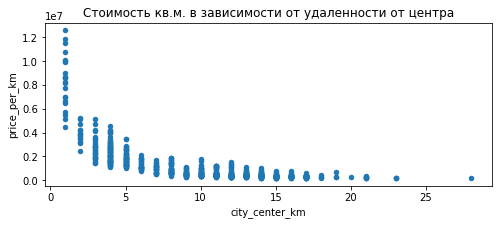

In [70]:
saint_p.plot(kind='scatter' , x='city_center_km', y='price_per_km', figsize=(8,3))
plt.title('Стоимость кв.м. в зависимости от удаленности от центра')
plt.show()

In [71]:
saint_p_center = saint_p.query('(city_center_km <= 6)')

In [72]:
saint_p_not_center = saint_p.query('(city_center_km > 6)')

In [73]:
saint_p_center.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'live_coef', 'kitchen_coef',
       'weekday', 'month', 'year', 'price_per_square_meter',
       'proportion_living_to_total_area', 'proportion_kitchen_to_total_area',
       'floor_category', 'city_center_km', 'price_per_km'],
      dtype='object')

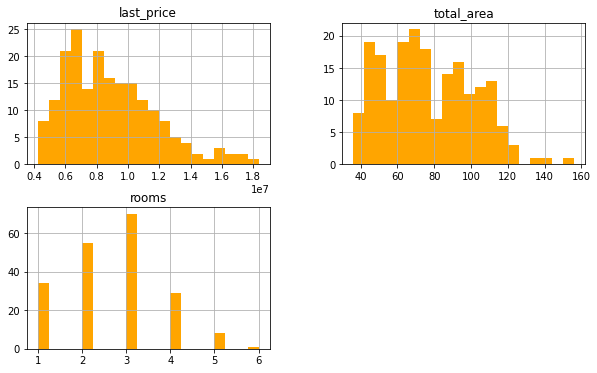

In [74]:
saint_p_center.hist(column=["last_price", "total_area", "rooms"], bins =20, figsize=(10, 6),color='orange')
plt.show()

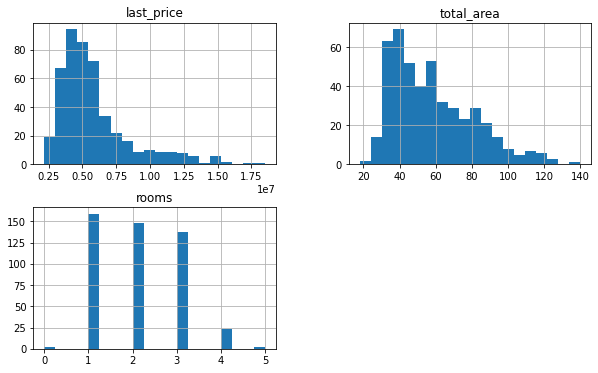

In [75]:
saint_p_not_center.hist(column=["last_price", "total_area", "rooms"], bins =20, figsize=(10, 6))
plt.show()

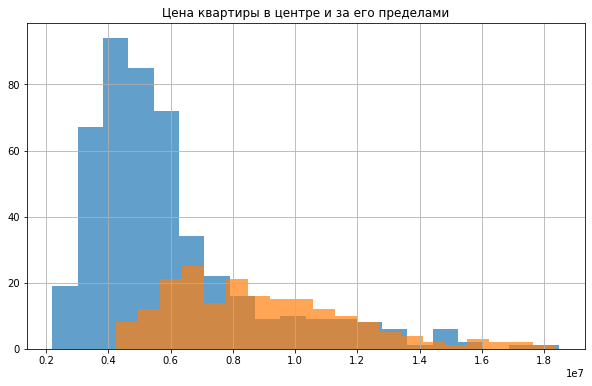

In [76]:
saint_p_not_center['last_price'].hist(bins =20, figsize=(10, 6),alpha=0.7)
saint_p_center['last_price'].hist(bins =20, figsize=(10, 6),alpha=0.7)
plt.title('Цена квартиры в центре и за его пределами')
plt.show()

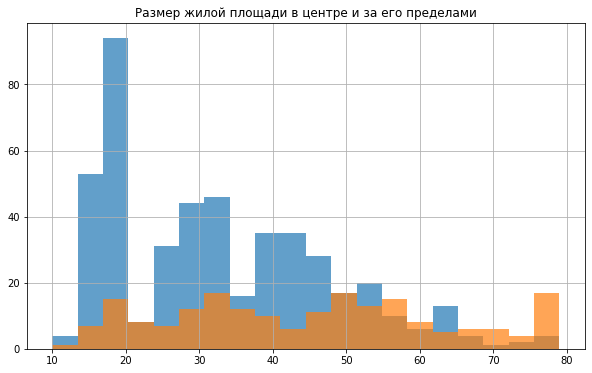

In [77]:
saint_p_not_center['living_area'].hist(bins =20, figsize=(10, 6),alpha=0.7)
saint_p_center['living_area'].hist(bins =20, figsize=(10, 6),alpha=0.7)
plt.title('Размер жилой площади в центре и за его пределами')
plt.show()

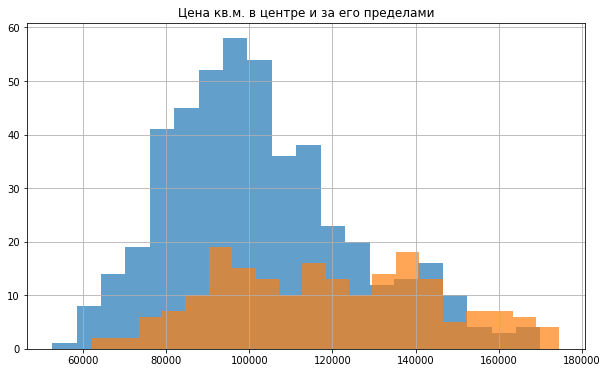

In [78]:
saint_p_not_center['price_per_square_meter'].hist(bins =20, figsize=(10, 6),alpha=0.7)
saint_p_center['price_per_square_meter'].hist(bins =20, figsize=(10, 6),alpha=0.7)
plt.title('Цена кв.м. в центре и за его пределами')
plt.show()

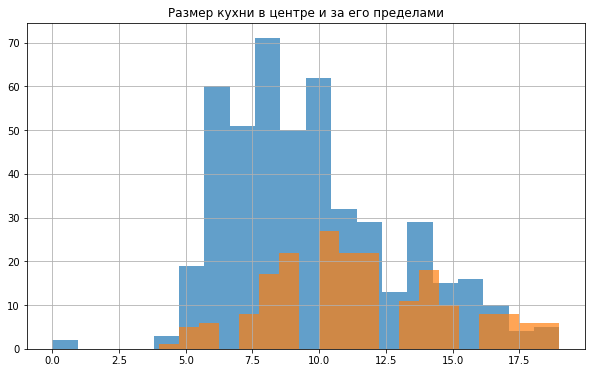

In [79]:
saint_p_not_center['kitchen_area'].hist(bins =20, figsize=(10, 6),alpha=0.7)
saint_p_center['kitchen_area'].hist(bins =20, figsize=(10, 6),alpha=0.7)
plt.title('Размер кухни в центре и за его пределами')
plt.show()

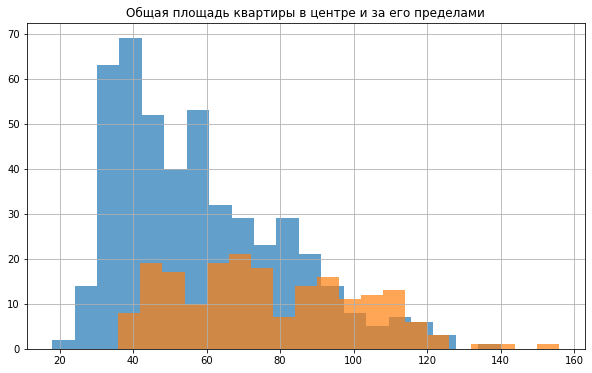

In [80]:
saint_p_not_center['total_area'].hist(bins =20, figsize=(10, 6),alpha=0.7)
saint_p_center['total_area'].hist(bins =20, figsize=(10, 6),alpha=0.7)
plt.title('Общая площадь квартиры в центре и за его пределами')
plt.show()

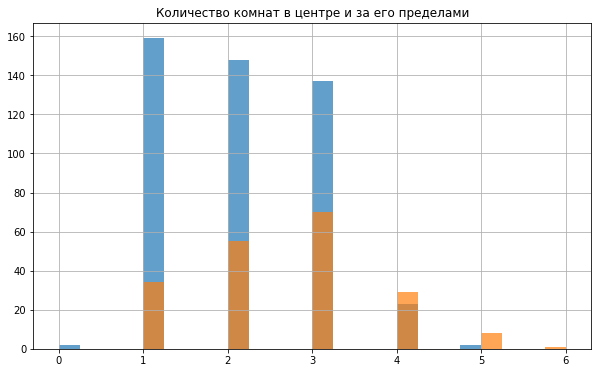

In [81]:
saint_p_not_center['rooms'].hist(bins =20, figsize=(10, 6),alpha=0.7)
saint_p_center['rooms'].hist(bins =20, figsize=(10, 6),alpha=0.7)
plt.title('Количество комнат в центре и за его пределами')
plt.show()

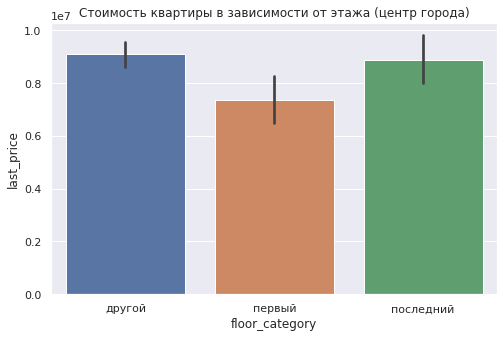

In [82]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(x="floor_category", y="last_price", data=saint_p_center) 
plt.title('Стоимость квартиры в зависимости от этажа (центр города)')
plt.show()

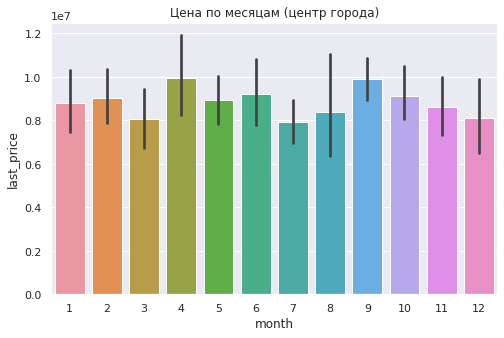

In [83]:
sns.barplot(x="month", y="last_price", data=saint_p_center) 
plt.title('Цена по месяцам (центр города)')
plt.show()

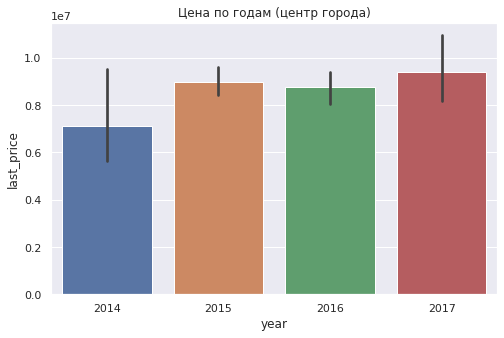

In [84]:
sns.barplot(x="year", y="last_price", data=saint_p_center) 
plt.title('Цена по годам (центр города)')
plt.show()

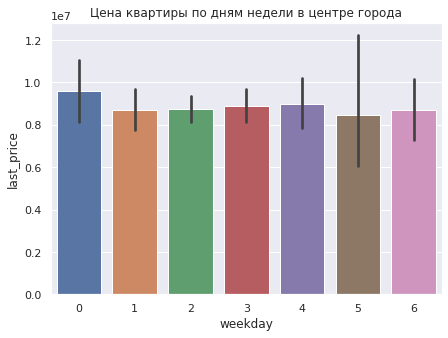

In [85]:
sns.set(rc={'figure.figsize':(7,5)})
sns.barplot(x="weekday", y="last_price", data=saint_p_center) 
plt.title('Цена квартиры по дням недели в центре города')
plt.show()

## Conclusion
1. На стоимость квартиры в Санкт-Петербурге влияют: стоимость квадратного метра, удаленность от центра, количество комнат, общая площадь
2. В центре города квартиры гораздо дороже, чем за его пределами
3. Количество комнат в квартирах центрального округа больше, чем за его пределами
4. Площадь квартир в центре города больше, чем за его пределами
5. В центре Питера люди предпочитают квартиры не на 1-ом и не на последнем этажах

Нам удалось выяснить, что больше всего объявлений по продаже квартир было в Санкт-Петербурге, а также в этом городе самые дорогие квартиры.
Если говорить в общих чертах, то мы убедились, что на стоимость квартиры  влияют: общая площадь, жилая площадь, площадь кухни, этаж (высоко ценится последний этаж), удалённость от центра.

Лучше всего квартиры продавались в 2014 г, а вот в центре Питера - в 2017

На примере Питера мы убедились, что жильё в центре (и его окрестностях) ценится гораздо дороже спальных районов.

1. Price for square meter, quantity of rooms and how many km from a flat to downtown impact the last price in Saint-Petersburg
2. In downtown flat more expensive than in different areas
3. Count of rooms in the downtown more than in different areas
4. In downtown total area bigger than in different areas
5. In downtown, people prefer flats, not on the first or last floor

We understood that the most popular city announcing flats is Sant Petersburg. In this city, apartments are more expensive than in different cities. The best year for sale was 2014, but in downtown - 2017
